In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import paper_utils as pu

In [75]:
df = pu.load_data(drop_dups=True)
df.head()

date     exdate  strike_price  lifeTime  volume  open_interest  \
0 2000-01-03 2000-03-18       1410000        75       0              1   
1 2000-01-03 2000-01-22       1505000        19       0             50   
2 2000-01-03 2000-06-17       1350000       166     290          14570   
3 2000-01-03 2000-01-22       1500000        19      57            505   
4 2000-01-03 2000-01-22       1540000        19       0              0   

   best_bid  best_ask  daysToExpiry  
0    36.750    38.750            75  
1    55.250    57.250            19  
2    40.750    42.750           166  
3    51.625    53.625            19  
4    84.875    86.875            19

In [76]:
import stock_apis as sa

In [77]:
client = sa.get_tiingo_client()

In [78]:
df_spy = client.get_dataframe('SPY','2000-01-03','2019-12-31').reset_index()[['date','adjClose']]

In [79]:
df_spy['date'] = pd.to_datetime(df_spy['date']).dt.tz_localize(None)

In [80]:
df = df.merge(df_spy, how = 'outer', on = 'date', validate = 'm:1')

In [81]:
df.head()

date     exdate  strike_price  lifeTime  volume  open_interest  \
0 2000-01-03 2000-03-18     1410000.0      75.0     0.0            1.0   
1 2000-01-03 2000-01-22     1505000.0      19.0     0.0           50.0   
2 2000-01-03 2000-06-17     1350000.0     166.0   290.0        14570.0   
3 2000-01-03 2000-01-22     1500000.0      19.0    57.0          505.0   
4 2000-01-03 2000-01-22     1540000.0      19.0     0.0            0.0   

   best_bid  best_ask  daysToExpiry   adjClose  
0    36.750    38.750          75.0  98.511539  
1    55.250    57.250          19.0  98.511539  
2    40.750    42.750         166.0  98.511539  
3    51.625    53.625          19.0  98.511539  
4    84.875    86.875          19.0  98.511539

In [103]:
df['moneyness'] = 1 - df['adjClose'] / df['strike_price'] * 1e4

In [83]:
df['yrMonth'] = df['date'].dt.strftime('%Y-%m')

In [84]:
df_end_of_month = df.groupby('yrMonth')['date'].max().reset_index()
df_end_of_month.columns = ['yrMonth','endOfMonth']

In [85]:
df = df.merge(df_end_of_month, how = 'left', on = 'yrMonth', validate = 'm:1')

In [86]:
idx = df['date'] == df['endOfMonth']
idx&= df['moneyness'] <= -0.05
idx&= df['daysToExpiry'] >= 30

In [87]:
idx.sum()

99719

In [88]:
len(idx)

7573627

In [89]:
df['mid'] = (df['best_bid'] + df['best_ask']) / 2

In [90]:
idx = df['moneyness'] < 0.01
idx&= df['moneyness'] > -0.01

In [91]:
idx.sum()

290432

In [92]:
df[idx][df[idx]['daysToExpiry'] == df[idx]['daysToExpiry'].max()]

date     exdate  strike_price  lifeTime  volume  open_interest  \
965226  2009-12-23 2012-12-22      900000.0    1095.0     0.0            0.0   
1200374 2010-12-22 2013-12-21     1025000.0    1095.0     0.0            0.0   
1455675 2011-12-21 2014-12-20     1050000.0    1095.0     0.0            0.0   

         best_bid  best_ask  daysToExpiry    adjClose  moneyness  yrMonth  \
965226       93.8     100.1        1095.0   90.312892   0.003477  2009-12   
1200374     104.5     112.0        1095.0  103.463193   0.009397  2010-12   
1455675     152.8     168.7        1095.0  104.274414  -0.006910  2011-12   

        endOfMonth     mid  
965226  2009-12-31   96.95  
1200374 2010-12-31  108.25  
1455675 2011-12-30  160.75

In [98]:
idx = df['exdate'] == pd.to_datetime('2013-12-21')
idx&= df['strike_price'] == 1025000.0
idx&= df['lifeTime'] == 1095.0

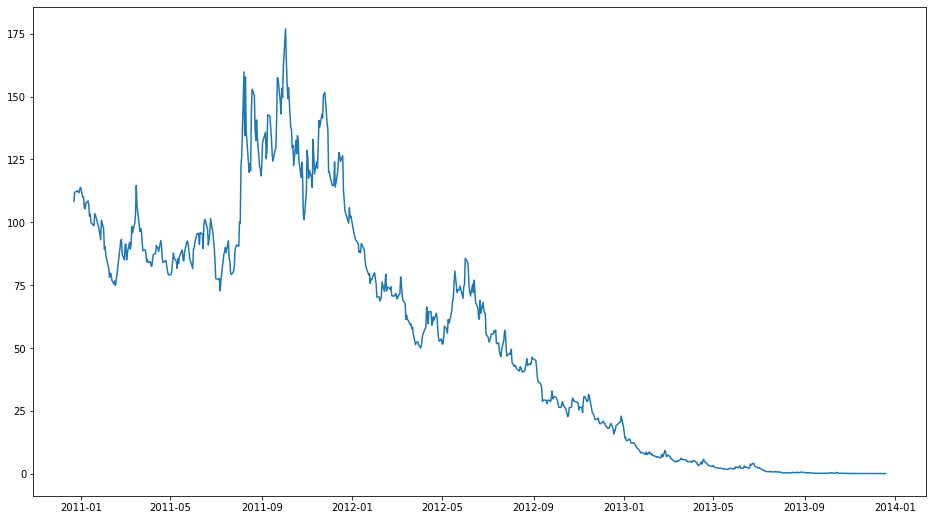

In [99]:
fig, ax = plt.subplots(figsize = (16,9))
df_plt = df[idx][['date','mid']].sort_values('date').reset_index(drop = True)
plt.plot(df_plt['date'], df_plt['mid'])

In [100]:
df.head()

date     exdate  strike_price  lifeTime  volume  open_interest  \
0 2000-01-03 2000-03-18     1410000.0      75.0     0.0            1.0   
1 2000-01-03 2000-01-22     1505000.0      19.0     0.0           50.0   
2 2000-01-03 2000-06-17     1350000.0     166.0   290.0        14570.0   
3 2000-01-03 2000-01-22     1500000.0      19.0    57.0          505.0   
4 2000-01-03 2000-01-22     1540000.0      19.0     0.0            0.0   

   best_bid  best_ask  daysToExpiry   adjClose  moneyness  yrMonth endOfMonth  \
0    36.750    38.750          75.0  98.511539  -0.301337  2000-01 2000-01-31   
1    55.250    57.250          19.0  98.511539  -0.345438  2000-01 2000-01-31   
2    40.750    42.750         166.0  98.511539  -0.270285  2000-01 2000-01-31   
3    51.625    53.625          19.0  98.511539  -0.343256  2000-01 2000-01-31   
4    84.875    86.875          19.0  98.511539  -0.360315  2000-01 2000-01-31   

      mid  
0  37.750  
1  56.250  
2  41.750  
3  52.625  
4  85.875

In [128]:
slct = ['exdate','strike_price','lifeTime','yrMonth','endOfMonth']
calc = ['mid','moneyness','daysToExpiry']
df_monthly = df.groupby(slct)[calc].last().reset_index().sort_values(slct)
df_monthly = df_monthly[df_monthly['exdate'] > df_monthly['endOfMonth']].reset_index(drop=True)

In [132]:
df_monthly.head(30)

exdate  strike_price  lifeTime  yrMonth endOfMonth      mid  moneyness  \
0  2000-02-19     1100000.0      47.0  2000-01 2000-01-31   0.1875   0.140617   
1  2000-02-19     1125000.0      47.0  2000-01 2000-01-31   0.2500   0.159714   
2  2000-02-19     1150000.0      47.0  2000-01 2000-01-31   0.3125   0.177981   
3  2000-02-19     1175000.0      47.0  2000-01 2000-01-31   0.5000   0.195471   
4  2000-02-19     1200000.0      47.0  2000-01 2000-01-31   0.9375   0.212232   
5  2000-02-19     1225000.0      47.0  2000-01 2000-01-31   1.2500   0.228309   
6  2000-02-19     1250000.0      47.0  2000-01 2000-01-31   2.0000   0.243743   
7  2000-02-19     1275000.0      47.0  2000-01 2000-01-31   3.2500   0.258572   
8  2000-02-19     1300000.0      47.0  2000-01 2000-01-31   5.8750   0.272830   
9  2000-02-19     1325000.0      47.0  2000-01 2000-01-31   9.0000   0.286550   
10 2000-02-19     1350000.0      47.0  2000-01 2000-01-31  13.6250   0.299762   
11 2000-02-19     1355000.0      25.0  2000-01 2000-01-31  14.7500   0.302346   
12 2000-02-19     1375000.0      47.0  2000-01 2000-01-31  20.6250   0.312494   
13 2000-02-19     1380000.0      39.0  2000-01 2000-01-31  21.8750   0.314985   
14 2000-02-19     1390000.0      22.0  2000-01 2000-01-31  25.8750   0.319913   
15 2000-02-19     1395000.0      22.0  2000-01 2000-01-31  28.0000   0.322350   
16 2000-02-19     1400000.0      47.0  2000-01 2000-01-31  29.5000   0.324770   
17 2000-02-19     1410000.0      23.0  2000-01 2000-01-31  34.6250   0.329559   
18 2000-02-19     1420000.0      23.0  2000-01 2000-01-31  40.3750   0.334281   
19 2000-02-19     1425000.0      47.0  2000-01 2000-01-31  43.8750   0.336617   
20 2000-02-19     1430000.0      23.0  2000-01 2000-01-31  46.8750   0.338936   
21 2000-02-19     1450000.0      47.0  2000-01 2000-01-31  61.3750   0.348054   
22 2000-02-19     1455000.0      29.0  2000-01 2000-01-31  65.3750   0.350295   
23 2000-02-19     1460000.0      29.0  2000-01 2000-01-31  69.5000   0.352520   
24 2000-02-19     1465000.0      47.0  2000-01 2000-01-31  73.7500   0.354729   
25 2000-02-19     1470000.0      47.0  2000-01 2000-01-31  78.0000   0.356924   
26 2000-02-19     1475000.0      47.0  2000-01 2000-01-31  82.3750   0.359104   
27 2000-02-19     1480000.0      29.0  2000-01 2000-01-31  87.0000   0.361269   
28 2000-02-19     1485000.0      29.0  2000-01 2000-01-31  91.5000   0.363420   
29 2000-02-19     1490000.0      29.0  2000-01 2000-01-31  96.1250   0.365556   

    daysToExpiry  
0           19.0  
1           19.0  
2           19.0  
3           19.0  
4           19.0  
5           19.0  
6           19.0  
7           19.0  
8           19.0  
9           19.0  
10          19.0  
11          19.0  
12          19.0  
13          19.0  
14          19.0  
15          19.0  
16          19.0  
17          19.0  
18          19.0  
19          19.0  
20          19.0  
21          19.0  
22          19.0  
23          19.0  
24          19.0  
25          19.0  
26          19.0  
27          19.0  
28          19.0  
29          19.0

In [131]:
df_monthly

exdate  strike_price  lifeTime  yrMonth endOfMonth        mid  \
0      2000-02-19     1100000.0      47.0  2000-01 2000-01-31     0.1875   
1      2000-02-19     1125000.0      47.0  2000-01 2000-01-31     0.2500   
2      2000-02-19     1150000.0      47.0  2000-01 2000-01-31     0.3125   
3      2000-02-19     1175000.0      47.0  2000-01 2000-01-31     0.5000   
4      2000-02-19     1200000.0      47.0  2000-01 2000-01-31     0.9375   
...           ...           ...       ...      ...        ...        ...   
350382 2021-12-17     4100000.0    1004.0  2019-05 2019-05-31  1287.6500   
350383 2021-12-17     4100000.0    1004.0  2019-06 2019-06-28  1123.0500   
350384 2021-12-17     4200000.0     976.0  2019-04 2019-04-30  1152.2000   
350385 2021-12-17     4200000.0     976.0  2019-05 2019-05-31  1380.7000   
350386 2021-12-17     4200000.0     976.0  2019-06 2019-06-28  1215.7500   

        moneyness  daysToExpiry  
0        0.140617          19.0  
1        0.159714          19.0  
2        0.177981          19.0  
3        0.195471          19.0  
4        0.212232          19.0  
...           ...           ...  
350382   0.347769         931.0  
350383   0.302379         903.0  
350384   0.319929         962.0  
350385   0.363298         931.0  
350386   0.318989         903.0  

[350387 rows x 8 columns]

In [122]:
df_monthly.tail(30)

exdate  strike_price  lifeTime  yrMonth endOfMonth      mid  \
482423 2021-12-17     3600000.0    1082.0  2019-06 2019-06-28   692.10   
482424 2021-12-17     3700000.0    1072.0  2019-01 2019-01-31   905.00   
482425 2021-12-17     3700000.0    1072.0  2019-02 2019-02-28   838.00   
482426 2021-12-17     3700000.0    1072.0  2019-03 2019-03-29   820.65   
482427 2021-12-17     3700000.0    1072.0  2019-04 2019-04-30   723.25   
482428 2021-12-17     3700000.0    1072.0  2019-05 2019-05-31   924.30   
482429 2021-12-17     3700000.0    1072.0  2019-06 2019-06-28   771.60   
482430 2021-12-17     3800000.0    1064.0  2019-01 2019-01-31   990.75   
482431 2021-12-17     3800000.0    1064.0  2019-02 2019-02-28   921.75   
482432 2021-12-17     3800000.0    1064.0  2019-03 2019-03-29   904.75   
482433 2021-12-17     3800000.0    1064.0  2019-04 2019-04-30   803.00   
482434 2021-12-17     3800000.0    1064.0  2019-05 2019-05-31  1013.05   
482435 2021-12-17     3800000.0    1064.0  2019-06 2019-06-28   855.70   
482436 2021-12-17     3900000.0    1050.0  2019-02 2019-02-28  1008.40   
482437 2021-12-17     3900000.0    1050.0  2019-03 2019-03-29   991.40   
482438 2021-12-17     3900000.0    1050.0  2019-04 2019-04-30   886.60   
482439 2021-12-17     3900000.0    1050.0  2019-05 2019-05-31  1103.55   
482440 2021-12-17     3900000.0    1050.0  2019-06 2019-06-28   943.20   
482441 2021-12-17     4000000.0    1031.0  2019-02 2019-02-28  1096.80   
482442 2021-12-17     4000000.0    1031.0  2019-03 2019-03-29  1080.30   
482443 2021-12-17     4000000.0    1031.0  2019-04 2019-04-30   973.20   
482444 2021-12-17     4000000.0    1031.0  2019-05 2019-05-31  1195.20   
482445 2021-12-17     4000000.0    1031.0  2019-06 2019-06-28  1032.95   
482446 2021-12-17     4100000.0    1004.0  2019-03 2019-03-29  1170.40   
482447 2021-12-17     4100000.0    1004.0  2019-04 2019-04-30  1061.95   
482448 2021-12-17     4100000.0    1004.0  2019-05 2019-05-31  1287.65   
482449 2021-12-17     4100000.0    1004.0  2019-06 2019-06-28  1123.05   
482450 2021-12-17     4200000.0     976.0  2019-04 2019-04-30  1152.20   
482451 2021-12-17     4200000.0     976.0  2019-05 2019-05-31  1380.70   
482452 2021-12-17     4200000.0     976.0  2019-06 2019-06-28  1215.75   

        moneyness  daysToExpiry  
482423   0.205487         903.0  
482424   0.294371        1051.0  
482425   0.271498        1023.0  
482426   0.258327         994.0  
482427   0.228028         962.0  
482428   0.277258         931.0  
482429   0.226960         903.0  
482430   0.312940        1051.0  
482431   0.290669        1023.0  
482432   0.277845         994.0  
482433   0.248343         962.0  
482434   0.296277         931.0  
482435   0.247303         903.0  
482436   0.308857        1023.0  
482437   0.296362         994.0  
482438   0.267616         962.0  
482439   0.314321         931.0  
482440   0.266603         903.0  
482441   0.326135        1023.0  
482442   0.313953         994.0  
482443   0.285926         962.0  
482444   0.331463         931.0  
482445   0.284938         903.0  
482446   0.330686         994.0  
482447   0.303342         962.0  
482448   0.347769         931.0  
482449   0.302379         903.0  
482450   0.319929         962.0  
482451   0.363298         931.0  
482452   0.318989         903.0

In [114]:
df_monthly.sort_values(['exdate','strike_price','lifeTime','yrMonth'])

exdate  strike_price  lifeTime  yrMonth         mid  moneyness  \
0      2000-01-22      975000.0      19.0  2000-01     0.03125  -0.005599   
1      2000-01-22     1025000.0      19.0  2000-01     0.03125   0.043455   
2      2000-01-22     1050000.0      19.0  2000-01     0.03125   0.066230   
3      2000-01-22     1075000.0      19.0  2000-01     0.03125   0.087945   
4      2000-01-22     1100000.0      19.0  2000-01     0.03125   0.108674   
...           ...           ...       ...      ...         ...        ...   
482448 2021-12-17     4100000.0    1004.0  2019-05  1287.65000   0.347769   
482449 2021-12-17     4100000.0    1004.0  2019-06  1123.05000   0.302379   
482450 2021-12-17     4200000.0     976.0  2019-04  1152.20000   0.319929   
482451 2021-12-17     4200000.0     976.0  2019-05  1380.70000   0.363298   
482452 2021-12-17     4200000.0     976.0  2019-06  1215.75000   0.318989   

        daysToExpiry  
0                2.0  
1                2.0  
2                2.0  
3                2.0  
4                2.0  
...              ...  
482448         931.0  
482449         903.0  
482450         962.0  
482451         931.0  
482452         903.0  

[482453 rows x 7 columns]

In [113]:
df_monthly.head()

exdate  strike_price  lifeTime  yrMonth      mid  moneyness  \
0 2000-01-22      975000.0      19.0  2000-01  0.03125  -0.005599   
1 2000-01-22     1025000.0      19.0  2000-01  0.03125   0.043455   
2 2000-01-22     1050000.0      19.0  2000-01  0.03125   0.066230   
3 2000-01-22     1075000.0      19.0  2000-01  0.03125   0.087945   
4 2000-01-22     1100000.0      19.0  2000-01  0.03125   0.108674   

   daysToExpiry  
0           2.0  
1           2.0  
2           2.0  
3           2.0  
4           2.0

In [112]:
df_monthly.set_index('yrMonth').groupby(['exdate','strike_price','lifeTime'])['mid'].pct_change()

yrMonth
2000-01         NaN
2000-01         NaN
2000-01         NaN
2000-01         NaN
2000-01         NaN
             ...   
2019-05    0.212534
2019-06   -0.127830
2019-04         NaN
2019-05    0.198316
2019-06   -0.119468
Name: mid, Length: 482453, dtype: float64

In [104]:
df[df['moneyness'] > 0]

date     exdate  strike_price  lifeTime  volume  open_interest  \
0       2000-01-03 2000-03-18     1410000.0      75.0     0.0            1.0   
1       2000-01-03 2000-01-22     1505000.0      19.0     0.0           50.0   
2       2000-01-03 2000-06-17     1350000.0     166.0   290.0        14570.0   
3       2000-01-03 2000-01-22     1500000.0      19.0    57.0          505.0   
4       2000-01-03 2000-01-22     1540000.0      19.0     0.0            0.0   
...            ...        ...           ...       ...     ...            ...   
7573494 2019-06-28 2020-06-30     3800000.0     372.0     0.0            0.0   
7573495 2019-06-28 2020-06-30     3900000.0     372.0     0.0            0.0   
7573496 2019-06-28 2020-06-30     4000000.0     372.0     0.0            0.0   
7573497 2019-06-28 2020-06-30     4100000.0     372.0     0.0            0.0   
7573498 2019-06-28 2020-06-30     4200000.0     372.0     0.0            0.0   

         best_bid  best_ask  daysToExpiry    adjClose  moneyness  yrMonth  \
0          36.750    38.750          75.0   98.511539   0.301337  2000-01   
1          55.250    57.250          19.0   98.511539   0.345438  2000-01   
2          40.750    42.750         166.0   98.511539   0.270285  2000-01   
3          51.625    53.625          19.0   98.511539   0.343256  2000-01   
4          84.875    86.875          19.0   98.511539   0.360315  2000-01   
...           ...       ...           ...         ...        ...      ...   
7573494   824.100   848.000         368.0  286.024739   0.247303  2019-06   
7573495   921.200   945.200         368.0  286.024739   0.266603  2019-06   
7573496  1018.700  1042.500         368.0  286.024739   0.284938  2019-06   
7573497  1116.100  1140.000         368.0  286.024739   0.302379  2019-06   
7573498  1213.900  1237.900         368.0  286.024739   0.318989  2019-06   

        endOfMonth       mid  
0       2000-01-31    37.750  
1       2000-01-31    56.250  
2       2000-01-31    41.750  
3       2000-01-31    52.625  
4       2000-01-31    85.875  
...            ...       ...  
7573494 2019-06-28   836.050  
7573495 2019-06-28   933.200  
7573496 2019-06-28  1030.600  
7573497 2019-06-28  1128.050  
7573498 2019-06-28  1225.900  

[3872895 rows x 14 columns]

In [ ]:
df.groupby()

In [ ]:
df.groupby(['date',''])

In [31]:
df[df['date'] == pd.to_datetime('2000-01-31')]

date     exdate  strike_price  lifeTime  volume  open_interest  \
5026 2000-01-31 2000-02-19     1100000.0      47.0   428.0         2582.0   
5027 2000-01-31 2000-02-19     1125000.0      47.0     4.0         1747.0   
5028 2000-01-31 2000-02-19     1150000.0      47.0    45.0        13556.0   
5029 2000-01-31 2000-02-19     1175000.0      47.0   308.0         1439.0   
5030 2000-01-31 2000-02-19     1200000.0      47.0   165.0         5038.0   
...         ...        ...           ...       ...     ...            ...   
5287 2000-01-31 2001-12-22     1650000.0     719.0     0.0          103.0   
5288 2000-01-31 2001-12-22     1700000.0     719.0     0.0            0.0   
5289 2000-01-31 2001-12-22     1750000.0     715.0     0.0            0.0   
5290 2000-01-31 2001-12-22     1800000.0     715.0     0.0          100.0   
5291 2000-01-31 2001-12-22     1850000.0     715.0     0.0            0.0   

      best_bid  best_ask  daysToExpiry  adjClose  moneyness  
5026    0.0000    0.3750          19.0  94.53213  -0.140617  
5027    0.0000    0.5000          19.0  94.53213  -0.159714  
5028    0.0625    0.5625          19.0  94.53213  -0.177981  
5029    0.2500    0.7500          19.0  94.53213  -0.195471  
5030    0.6875    1.1875          19.0  94.53213  -0.212232  
...        ...       ...           ...       ...        ...  
5287  215.3750  218.3750         691.0  94.53213  -0.427078  
5288  239.1250  242.1250         691.0  94.53213  -0.443929  
5289  266.1250  269.1250         691.0  94.53213  -0.459816  
5290  295.5000  298.5000         691.0  94.53213  -0.474821  
5291  325.1250  328.1250         691.0  94.53213  -0.489016  

[266 rows x 11 columns]

In [29]:
df['moneyness'].describe().iloc[1:]

mean     0.167417
std      0.959804
min     -0.785213
25%     -0.119205
50%     -0.002207
75%      0.181082
max     27.741711
Name: moneyness, dtype: float64

In [10]:
df_spy.head()

date   adjClose
0 2000-01-03 00:00:00+00:00  98.511539
1 2000-01-04 00:00:00+00:00  94.659133
2 2000-01-05 00:00:00+00:00  94.828469
3 2000-01-06 00:00:00+00:00  93.304440
4 2000-01-07 00:00:00+00:00  98.723210